# M2 Agentic AI - Chart Generation (Qwen & GLM Edition)

This notebook is a variation of the original lab, adapted to demonstrate the **Reflection Pattern** using **Qwen (Tongyi Qianwen)** and **GLM (Zhipu AI)** models.

We will implement the same workflow:
1. **Generate (V1)**: Use `qwen3-max` to generate initial plotting code.
2. **Execute**: Run the code to create the chart.
3. **Reflect**: Use `glm-4` (or `qwen3-max`) to critique the chart and code.
4. **Regenerate (V2)**: Produce an improved chart based on the feedback.

## 1. Introduction
### 1.1. Lab overview

In this lab, you will implement the **reflection pattern** within an agentic workflow that generates data visualizations. A multi-modal LLM will review the first draft chart, identify potential improvements—such as chart type, labels, or color choices—and then rewrite the chart generation code to produce a more effective visualization.

The steps that the workflow will carry out are:

1. **Generate an initial version (V1):**
Use a Large Language Model (LLM) to create the first version of the plotting code.

2. **Execute code and create chart:** 
Run the generated code and display the resulting chart.

3. **Reflect on the output:**
Evaluate both the code and the chart using an LLM to detect areas for improvement (e.g., clarity, accuracy, design).

4. **Generate and execute improved version (V2):**
Produce a refined version of the plotting code based on reflection insights and render the enhanced chart.

## 2. Setup: Initialize environment and client

In this step, you import the key libraries that will support the workflow:  

- **`re`**: Python’s regular expression module.
- **`json`**: Provides functions to read and write JSON.
- **`utils`**: A custom helper module provided for this lab. **Note:** We have updated `utils.py` to support Qwen and GLM models via their OpenAI-compatible APIs.


In [ ]:
# Install required packages
%pip install pandas matplotlib openai anthropic python-dotenv Pillow

In [1]:
# Standard library imports
import re
import json

# Local helper module
import utils

In [2]:
import os
from openai import OpenAI

class OpenAICompatibleClient:
    """
    A unified client for interacting with OpenAI-compatible APIs (Qwen, GLM, DeepSeek, etc.).
    It automatically selects the correct API Key and Base URL based on the model name.
    """
    def __init__(self):
        # Load keys from environment
        self.configs = {
            "qwen": {
                "api_key": os.getenv("QWEN_API_KEY"),
                "base_url": os.getenv("QWEN_BASE_URL", "https://dashscope.aliyuncs.com/compatible-mode/v1")
            },
            "glm": {
                "api_key": os.getenv("ZHIPU_API_KEY"),
                "base_url": os.getenv("ZHIPU_BASE_URL", "https://open.bigmodel.cn/api/paas/v4/")
            },
            "gpt": {
                "api_key": os.getenv("OPENAI_API_KEY"),
                "base_url": None # Default OpenAI
            }
        }

    def _get_client(self, model: str) -> OpenAI:
        """Determine which client config to use based on model name prefix."""
        model_lower = model.lower()
        config = None
        
        if "qwen" in model_lower:
            config = self.configs["qwen"]
        elif "glm" in model_lower:
            config = self.configs["glm"]
        else:
            config = self.configs["gpt"]
            
        if not config["api_key"]:
            raise ValueError(f"API Key not found for model: {model}. Please check your .env file.")

        return OpenAI(api_key=config["api_key"], base_url=config["base_url"])

    def chat(self, model: str, messages: list, temperature: float = 0.7) -> str:
        """Standard chat completion."""
        client = self._get_client(model)
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature
        )
        return response.choices[0].message.content

    def chat_with_image(self, model: str, prompt: str, image_path: str) -> str:
        """Chat completion with an image attachment."""
        client = self._get_client(model)
        media_type, b64_str = utils.encode_image_b64(image_path)
        data_url = f"data:{media_type};base64,{b64_str}"
        
        response = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image_url", "image_url": {"url": data_url}},
                    ],
                }
            ],
        )
        return response.choices[0].message.content

# Initialize the global client
llm_client = OpenAICompatibleClient()

### 2.1. Loading the dataset
Let’s take a look at the coffee sales data to see what information is contained in the file.

In [3]:
# Use this utils.py function to load the data into a dataframe
df = utils.load_and_prepare_data('coffee_sales.csv')

# Grab a random sample to display
utils.print_html(df.sample(n=5), title="Random Sample of Coffee Sales Data")

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-08-04,08:37,card,ANON-0000-0000-0458,3.282,Cappuccino,3,8,2024
2025-02-17,07:01,card,ANON-0000-0000-1160,2.596,Americano,1,2,2025
2024-09-27,07:34,card,ANON-0000-0000-0674,3.282,Cappuccino,3,9,2024
2024-12-18,14:24,card,ANON-0000-0000-1016,3.576,Latte,4,12,2024
2024-10-10,12:24,card,ANON-0000-0000-0742,2.596,Americano,4,10,2024


## 3. Building the pipeline
### 3.1 Step 1 — Generate Code to Create a Chart (V1)

In this step, you’ll prompt an LLM to write Python code that generates a chart.
We will use **`qwen3-max`** for this step.

In [4]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    # Use our local llm_client instead of utils.get_response
    response = llm_client.chat(model=model, messages=[{"role": "user", "content": prompt}])
    return response

Now, try out the function using `qwen3-max`!

In [5]:
# Generate initial code using Qwen
code_v1 = generate_chart_code(
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.", 
    model="qwen3-max", 
    out_path_v1="chart_v1.png"
)

utils.print_html(code_v1, title="LLM output with first draft code (Qwen)")

### 3.2. Step 2 — Execute Code and Create Chart

Extract and execute the code generated by Qwen.


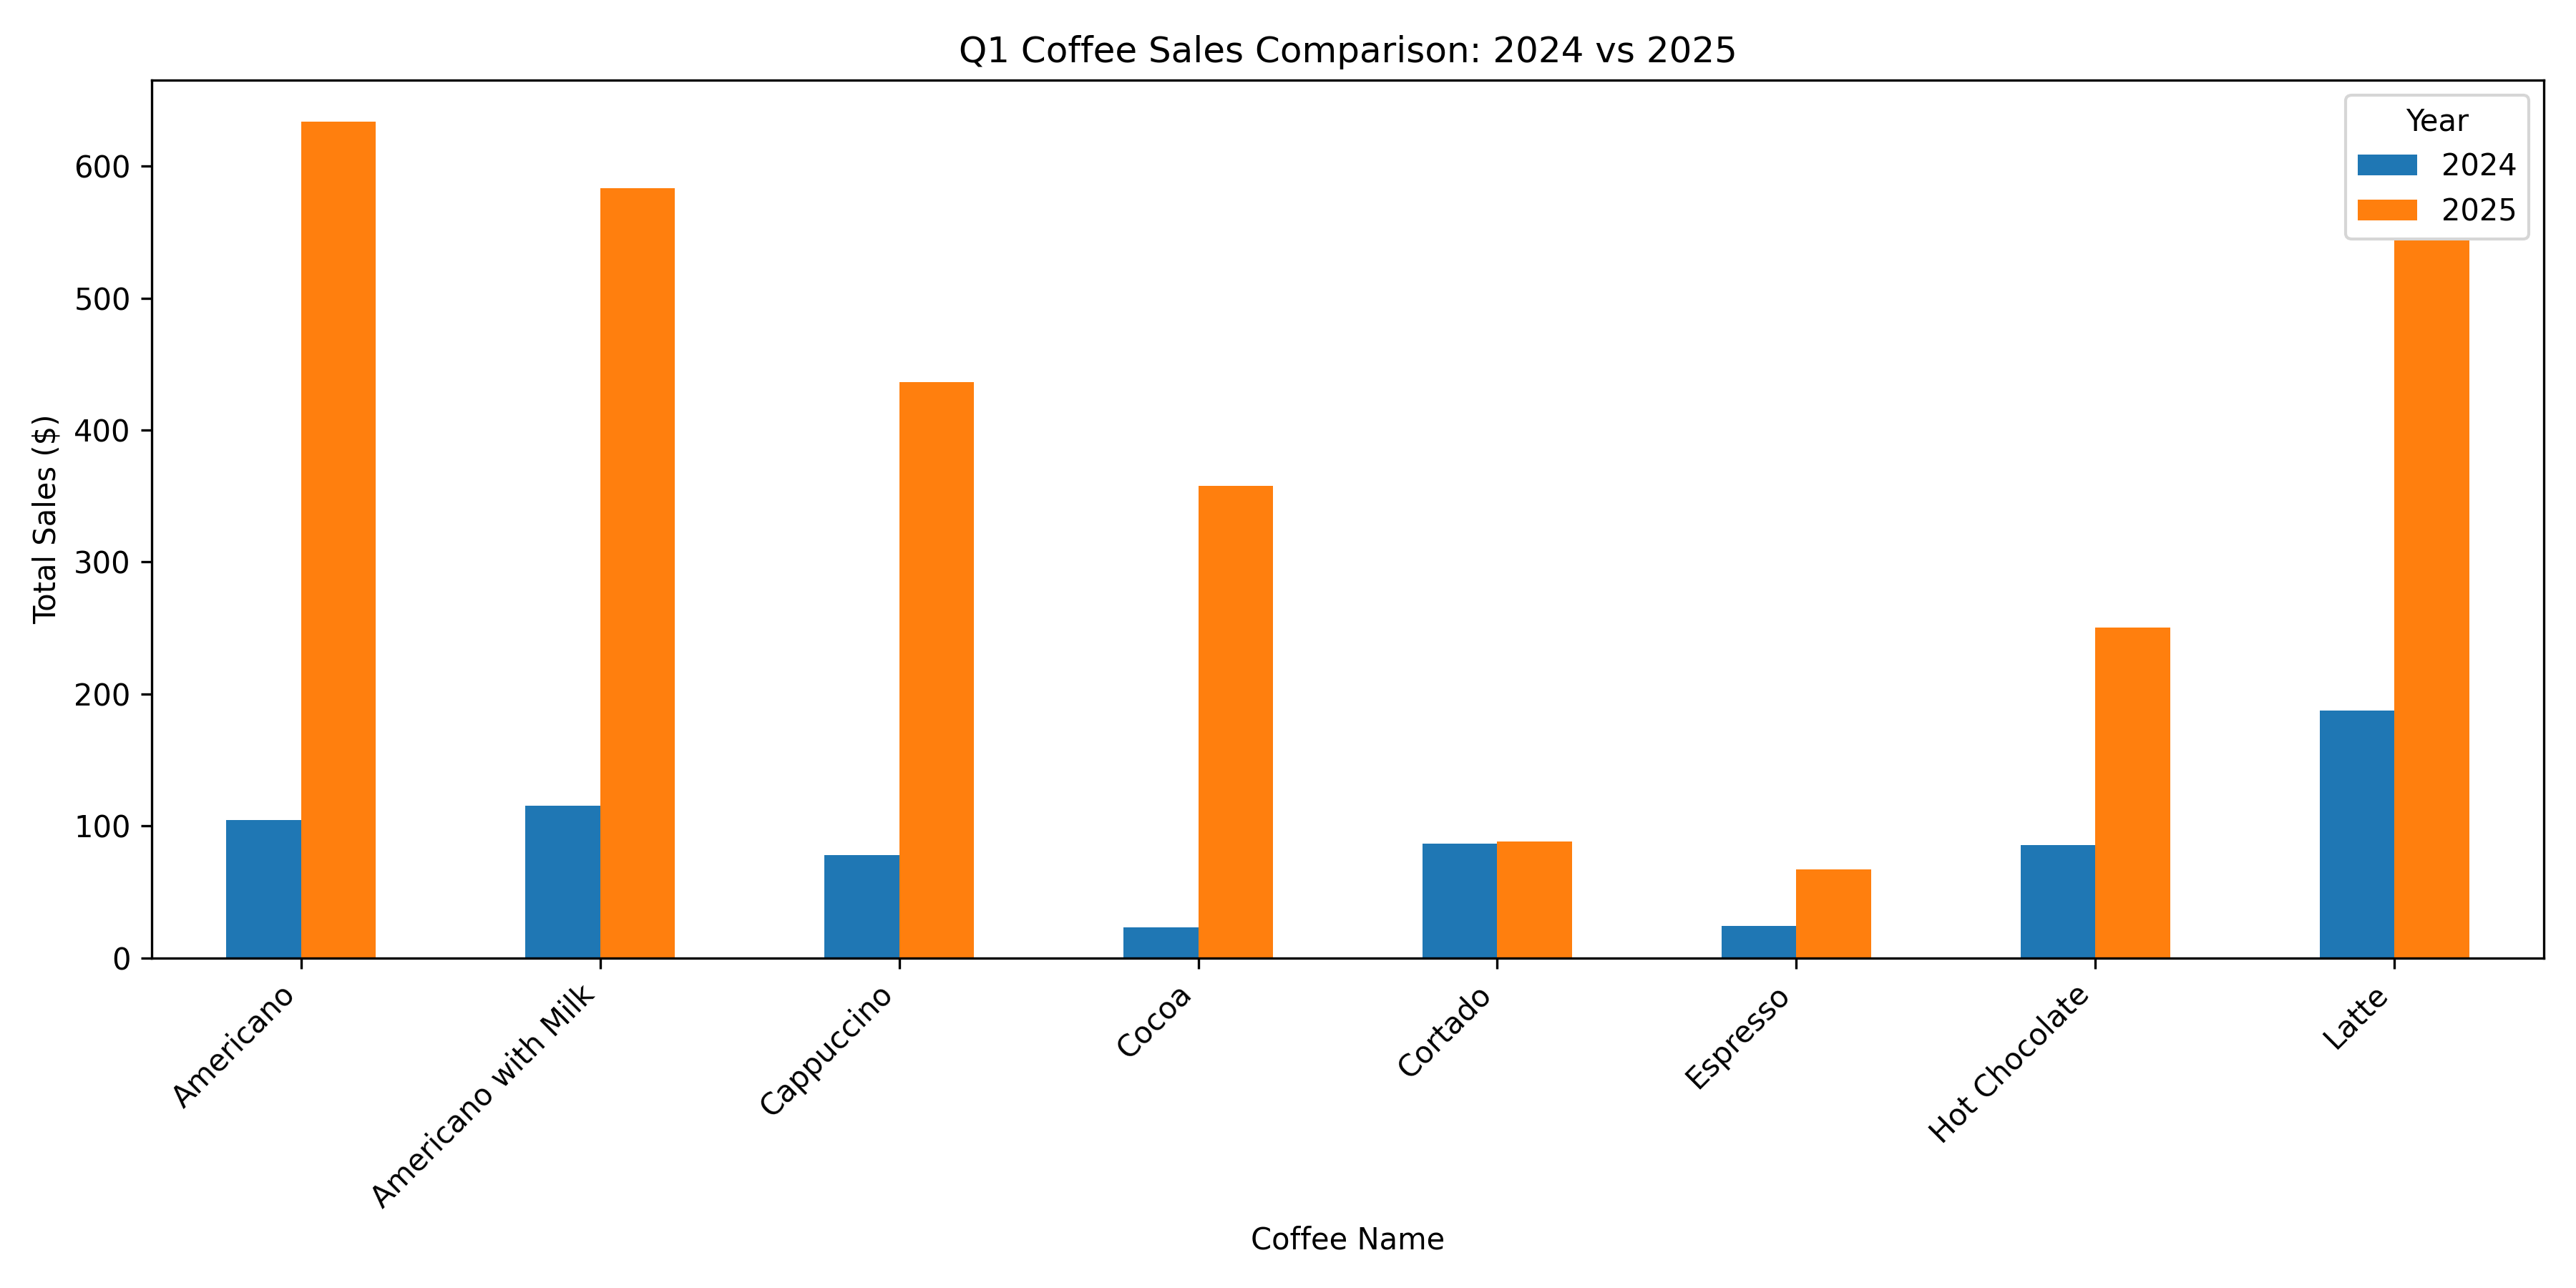

In [6]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
if match:
    initial_code = match.group(1).strip()
    utils.print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df}
    exec(initial_code, exec_globals)

# If code run successfully, the file chart_v1.png should have been generated
utils.print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

### 3.3. Step 3 — Reflect on the output

We will now use **`glm-4`** (or another model) to reflect on the chart generated by Qwen.

In [ ]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,  
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction, 
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    """
    
    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT!):
    1) Start with a JSON object containing a "feedback" field.
    Example: {{"feedback": "The legend is unclear..."}}

    2) Then, output the refined Python code wrapped in <execute_python> tags.

    HARD CONSTRAINTS:
    - The JSON must be valid.
    - Use pandas/matplotlib only.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close().
    - Include all imports.

    Instruction:
    {instruction}
    """

    # Use our local llm_client for image analysis
    content = llm_client.chat_with_image(model=model_name, prompt=prompt, image_path=chart_path)
    
    # Debug: print raw content length to see if we got anything
    print(f"[Debug] Raw response length: {len(content)}")

    # --- Robust Parsing Logic ---
    feedback = ""
    refined_code_body = ""
    
    # 1. Try to find JSON object using regex (non-greedy)
    m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
    if m_json:
        try:
            obj = json.loads(m_json.group(0))
            feedback = obj.get("feedback", "")
            # Check if model put code inside JSON (common deviation)
            if "code" in obj:
                refined_code_body = obj["code"]
            elif "refined_code" in obj:
                refined_code_body = obj["refined_code"]
            elif "execute_python" in obj:
                refined_code_body = obj["execute_python"]
        except Exception:
            pass 

    # 2. Fallback for feedback
    if not feedback:
        parts = content.split("<execute_python>")
        if len(parts) > 1:
            raw_feedback = parts[0].strip()
            feedback = re.sub(r"```json|```", "", raw_feedback).strip()
        else:
            feedback = content if content else "No response from model."

    # 3. Extract refined code (if not found in JSON)
    if not refined_code_body:
        m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
        if m_code:
            refined_code_body = m_code.group(1).strip()
    
    # 4. Fallback for code: markdown block
    if not refined_code_body:
        m_md = re.search(r"```python([\s\S]*?)```", content)
        if m_md:
            refined_code_body = m_md.group(1).strip()

    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    return feedback, refined_code

### 3.4 Step 4 — Generate and Execute Improved Version (V2)

Let's use `glm-4` to reflect and regenerate.

In [12]:
# Generate feedback alongside reflected code using GLM-4V (Vision Model)
# Note: We switched from 'glm-4' to 'glm-4v' because the standard 'glm-4' does not support image inputs.
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",            
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.", 
    model_name="glm-4v", 
    out_path_v2="chart_v2.png",
    code_v1=code_v1,   # pass in the original code for context        
)

utils.print_html(feedback, title="Feedback on V1 Chart (GLM-4V)")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")

[Debug] Raw response length: 1099



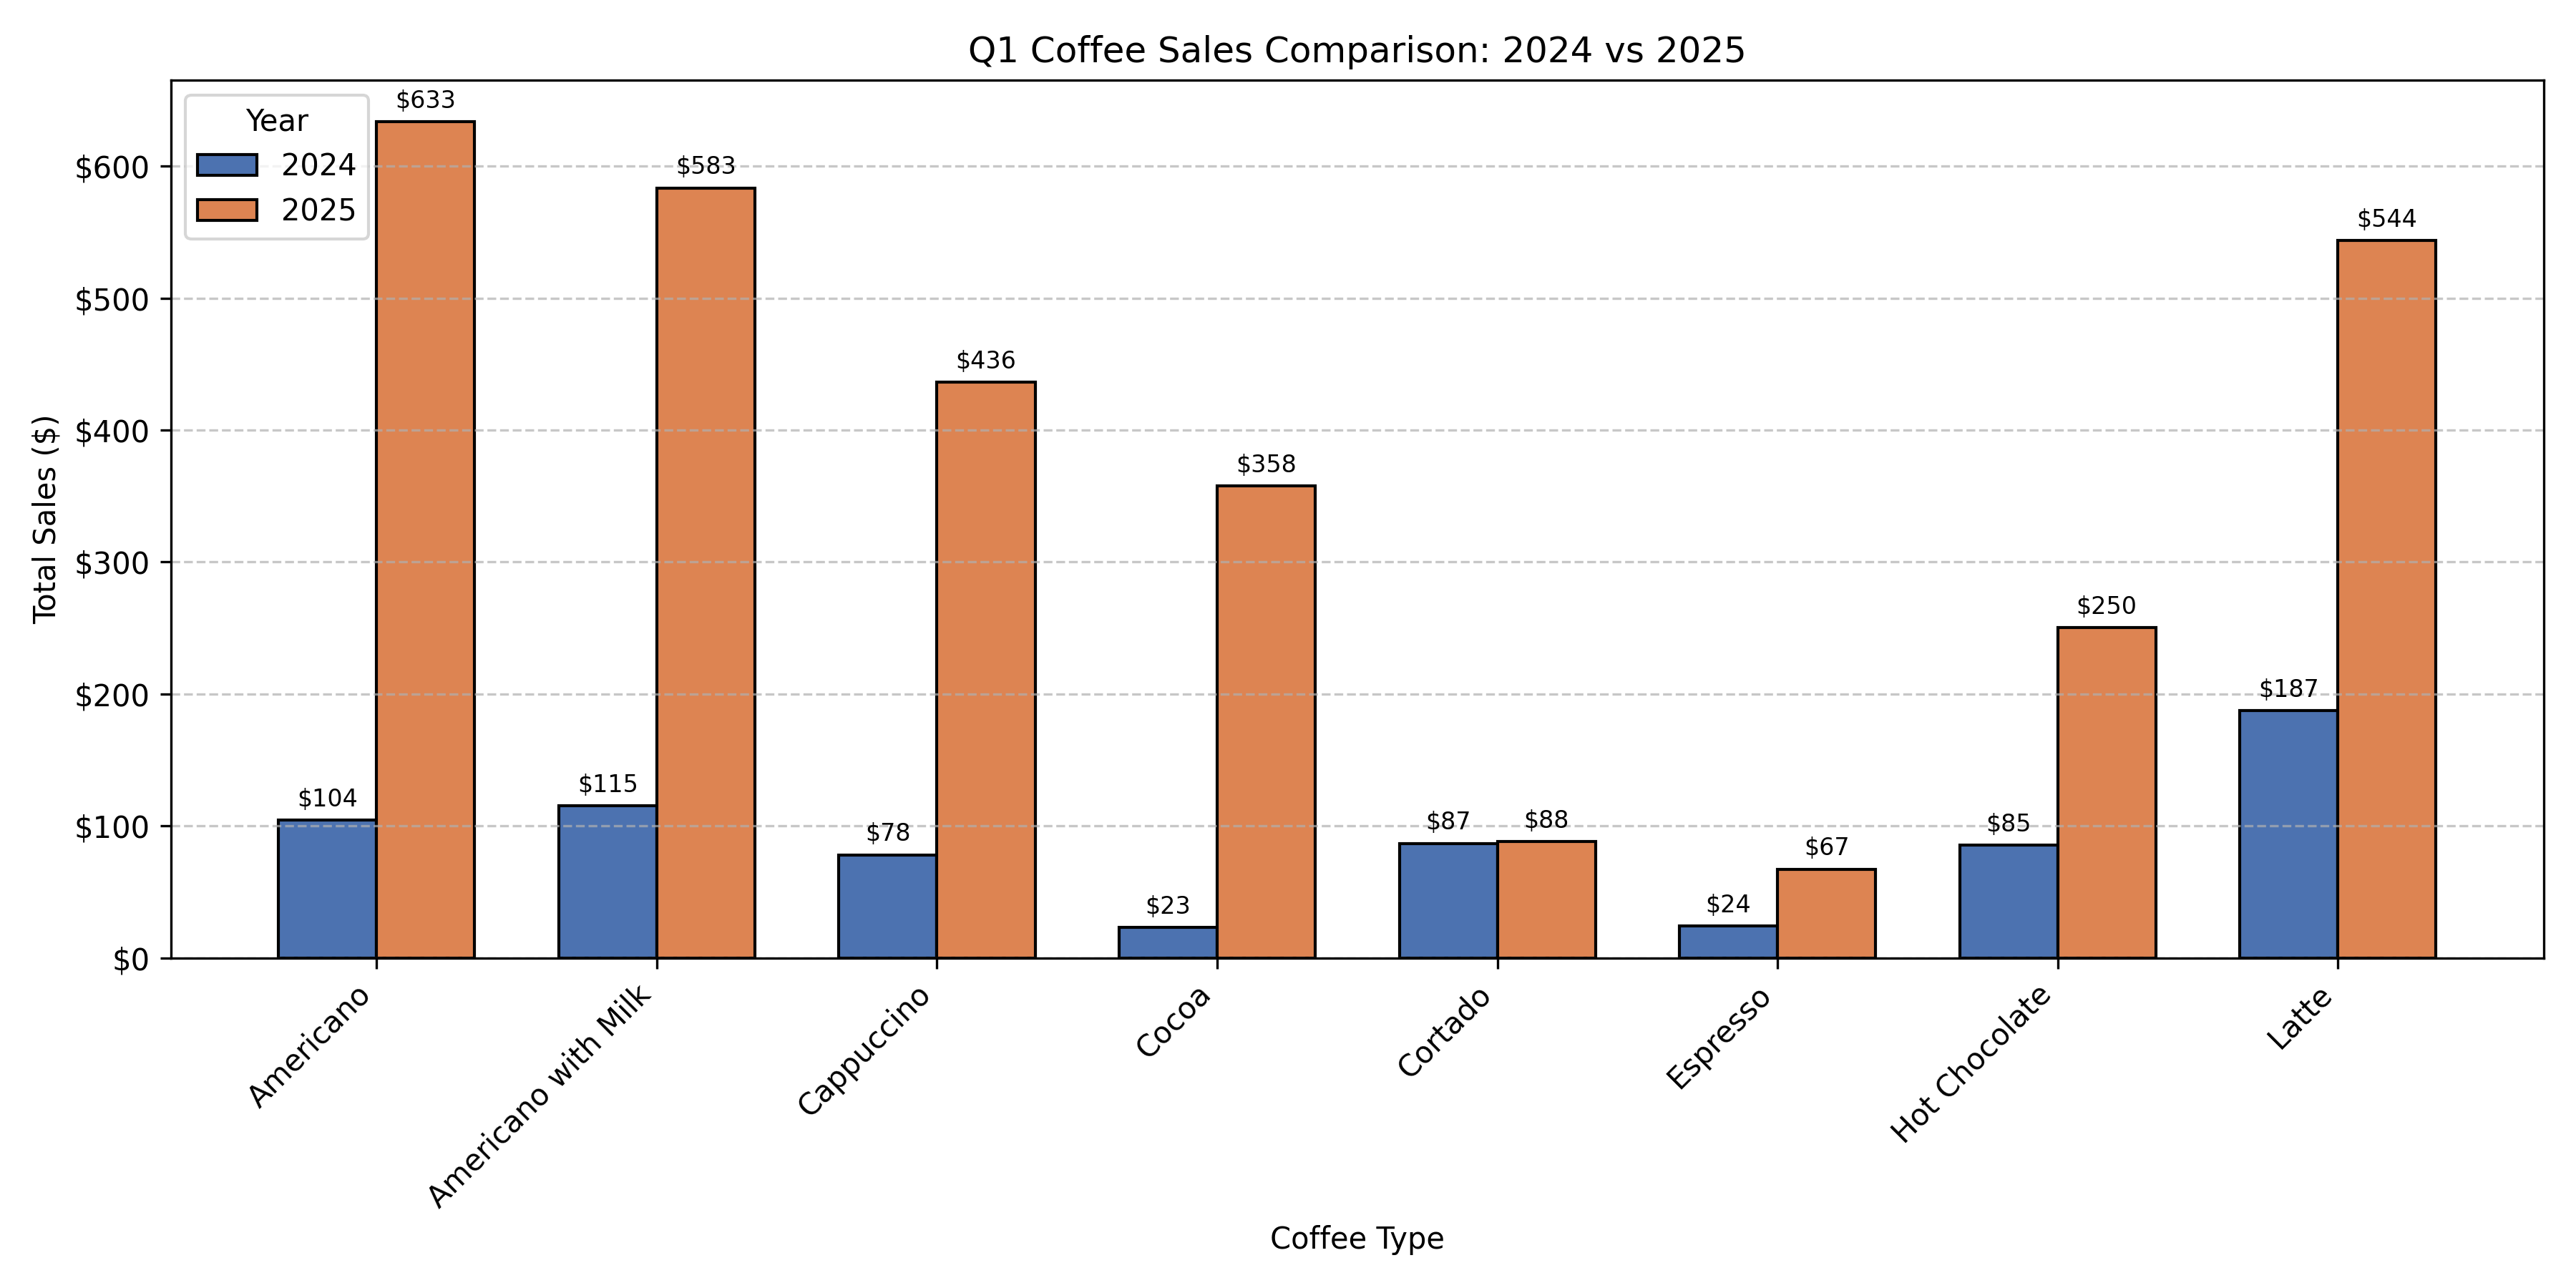

In [13]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
if match:
    reflected_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(reflected_code, exec_globals)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

### 4. Put it all together — creating the end-to-end workflow

In [16]:
def run_workflow(
    dataset_path: str,
    user_instructions: str,
    generation_model: str,
    reflection_model: str,   
    image_basename: str = "chart",
):
    """
    End-to-end pipeline:
      1) load dataset
      2) generate V1 code
      3) execute V1 → produce chart_v1.png
      4) reflect on V1 (image + original code) → feedback + refined code
      5) execute V2 → produce chart_v2.png

    Returns a dict with all artifacts (codes, feedback, image paths).
    """
    # 0) Load dataset; utils handles parsing and feature derivations (e.g., year/quarter)
    df = utils.load_and_prepare_data(dataset_path)
    utils.print_html(df.sample(n=5), title="Random Sample of Dataset")

    # Paths to store charts
    out_v1 = f"{image_basename}_v1.png"
    out_v2 = f"{image_basename}_v2.png"

    # 1) Generate code (V1)
    utils.print_html(f"Step 1: Generating chart code (V1) with {generation_model}… 📈")
    code_v1 = generate_chart_code(
        instruction=user_instructions,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="LLM output with first draft code (V1)")

    # 2) Execute V1 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 2: Executing chart code (V1)… 💻")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
    if match:
        initial_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(initial_code, exec_globals)
    utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # 3) Reflect on V1 (image + original code) to get feedback and refined code (V2)
    utils.print_html(f"Step 3: Reflecting on V1 with {reflection_model}… 🔁")
    feedback, code_v2 = reflect_on_image_and_regenerate(
        chart_path=out_v1,
        instruction=user_instructions,
        model_name=reflection_model,
        out_path_v2=out_v2,
        code_v1=code_v1,  # pass original code for context
    )
    utils.print_html(feedback, title="Reflection feedback on V1")
    utils.print_html(code_v2, title="LLM output with revised code (V2)")

    # 4) Execute V2 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 4: Executing refined chart code (V2)… 🖼️")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
    if match:
        reflected_code = match.group(1).strip()
        exec_globals = {"df": df}
        try:
            exec(reflected_code, exec_globals)
        except Exception as e:
            utils.print_html(f"Error executing V2 code: {e}")
    
    # Check if file exists before trying to display it
    if os.path.exists(out_v2):
        utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")
    else:
        utils.print_html(f"⚠️ Warning: {out_v2} was not generated. The model might have failed to produce valid code.", title="Execution Warning")

    return {
        "code_v1": code_v1,
        "chart_v1": out_v1,
        "feedback": feedback,
        "code_v2": code_v2,
        "chart_v2": out_v2,
    }

### 4.2. Try the workflow with Qwen and GLM

We will use:
- **Generation**: `qwen3-max`
- **Reflection**: `glm-4`

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-09-22,09:57,card,ANON-0000-0000-0333,2.792,Americano with Milk,3,9,2024
2025-03-15,07:17,card,ANON-0000-0000-1163,3.086,Americano with Milk,1,3,2025
2025-01-13,15:23,card,ANON-0000-0000-1099,3.576,Latte,1,1,2025
2024-12-28,17:43,card,ANON-0000-0000-0507,3.576,Latte,4,12,2024
2024-06-14,11:09,card,ANON-0000-0000-0297,2.792,Americano,2,6,2024



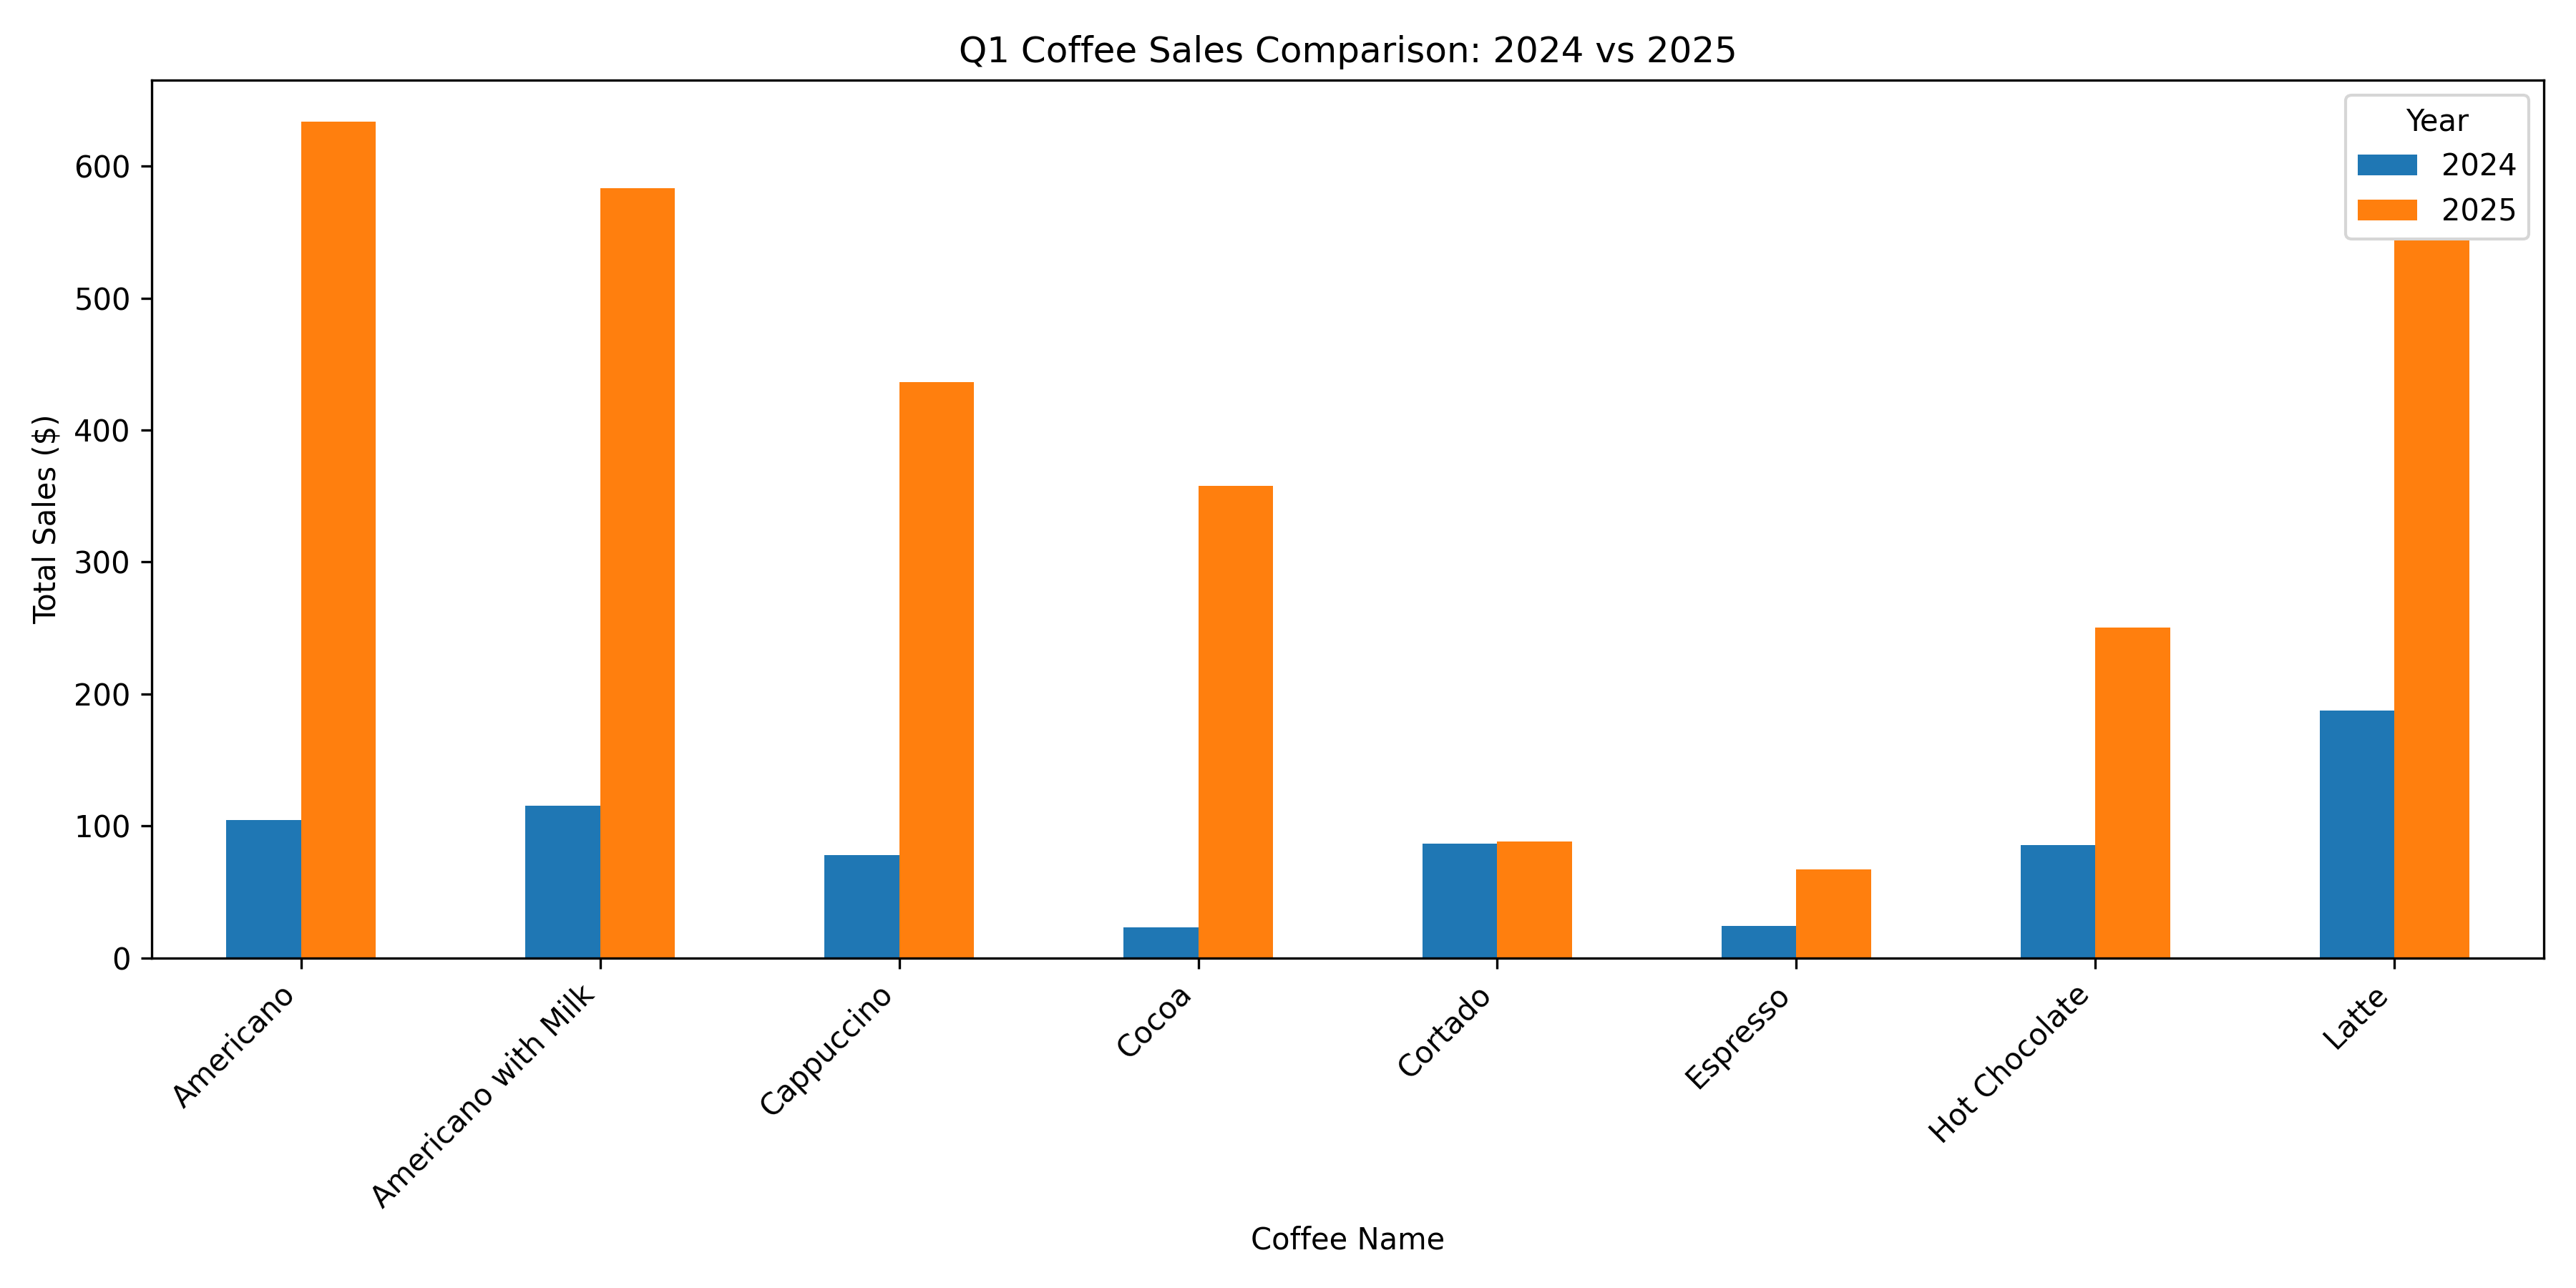

[Debug] Raw response length: 971


In [17]:
# Here, insert your updates
user_instructions="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv." 
generation_model="qwen3-max"
reflection_model="glm-4v" # Switched to glm-4v for vision capabilities
image_basename="drink_sales_qwen_glm"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-05-22,09:16,card,ANON-0000-0000-0097,3.282,Americano with Milk,2,5,2024
2024-06-03,13:27,card,ANON-0000-0000-0009,3.772,Latte,2,6,2024
2025-03-06,10:37,card,ANON-0000-0000-1198,2.596,Americano,1,3,2025
2024-09-02,07:18,card,ANON-0000-0000-0564,2.792,Americano with Milk,3,9,2024
2024-07-25,06:14,card,ANON-0000-0000-0399,3.282,Latte,3,7,2024



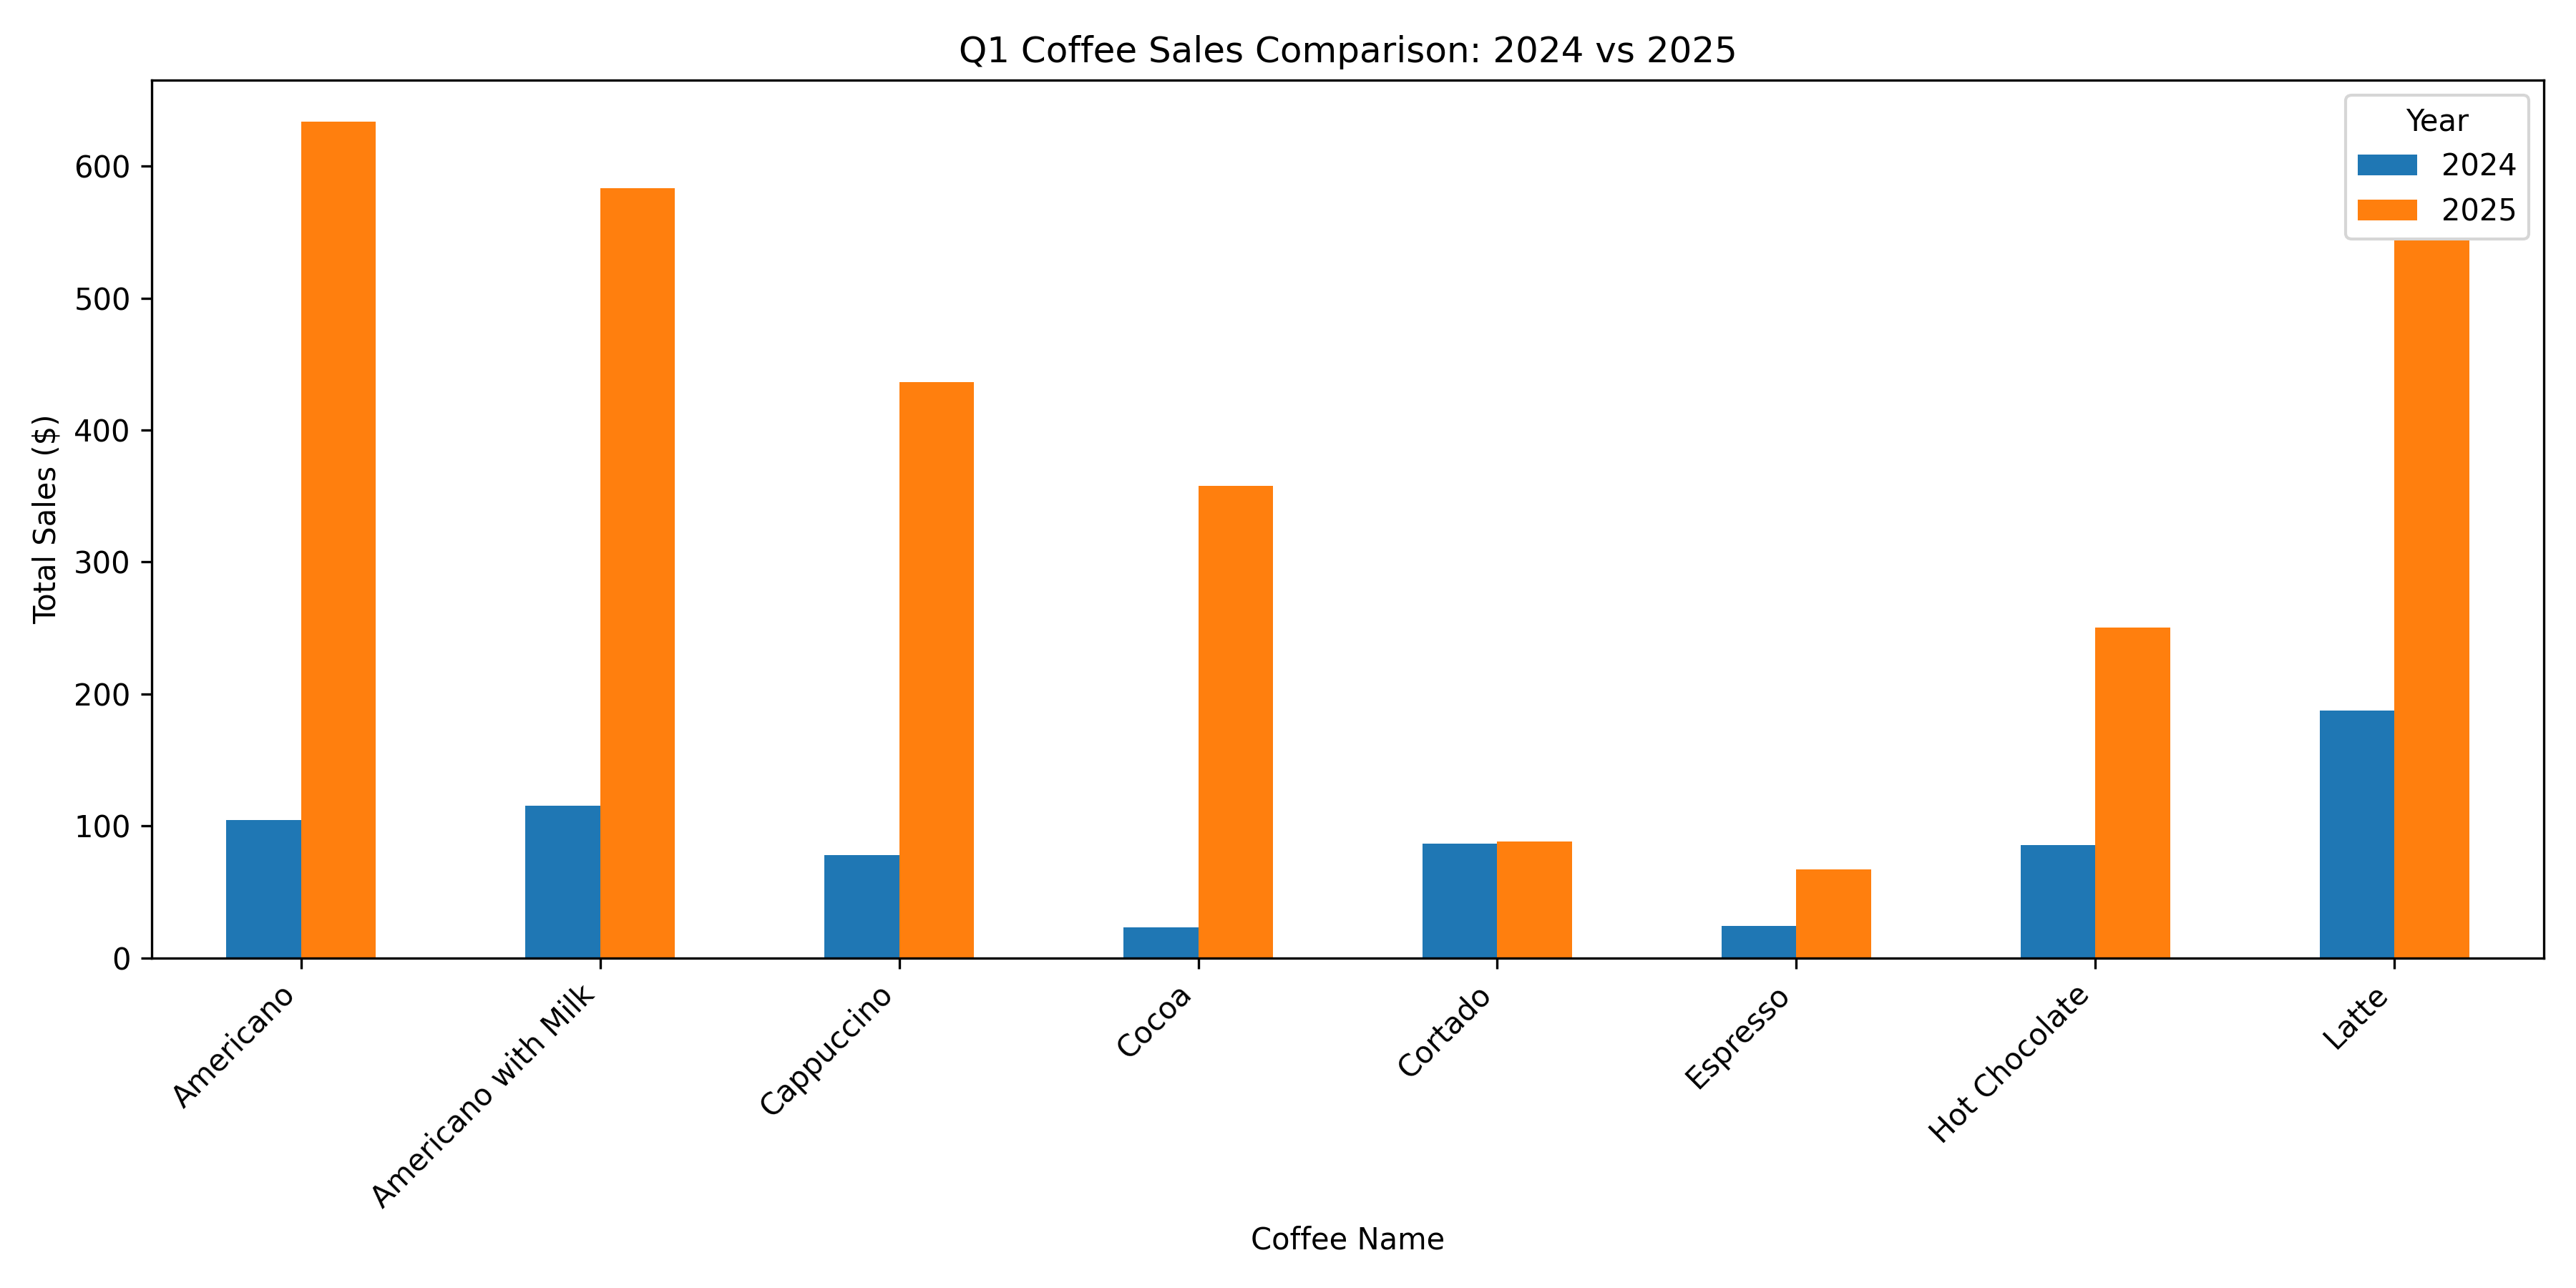

[Debug] Raw response length: 1991



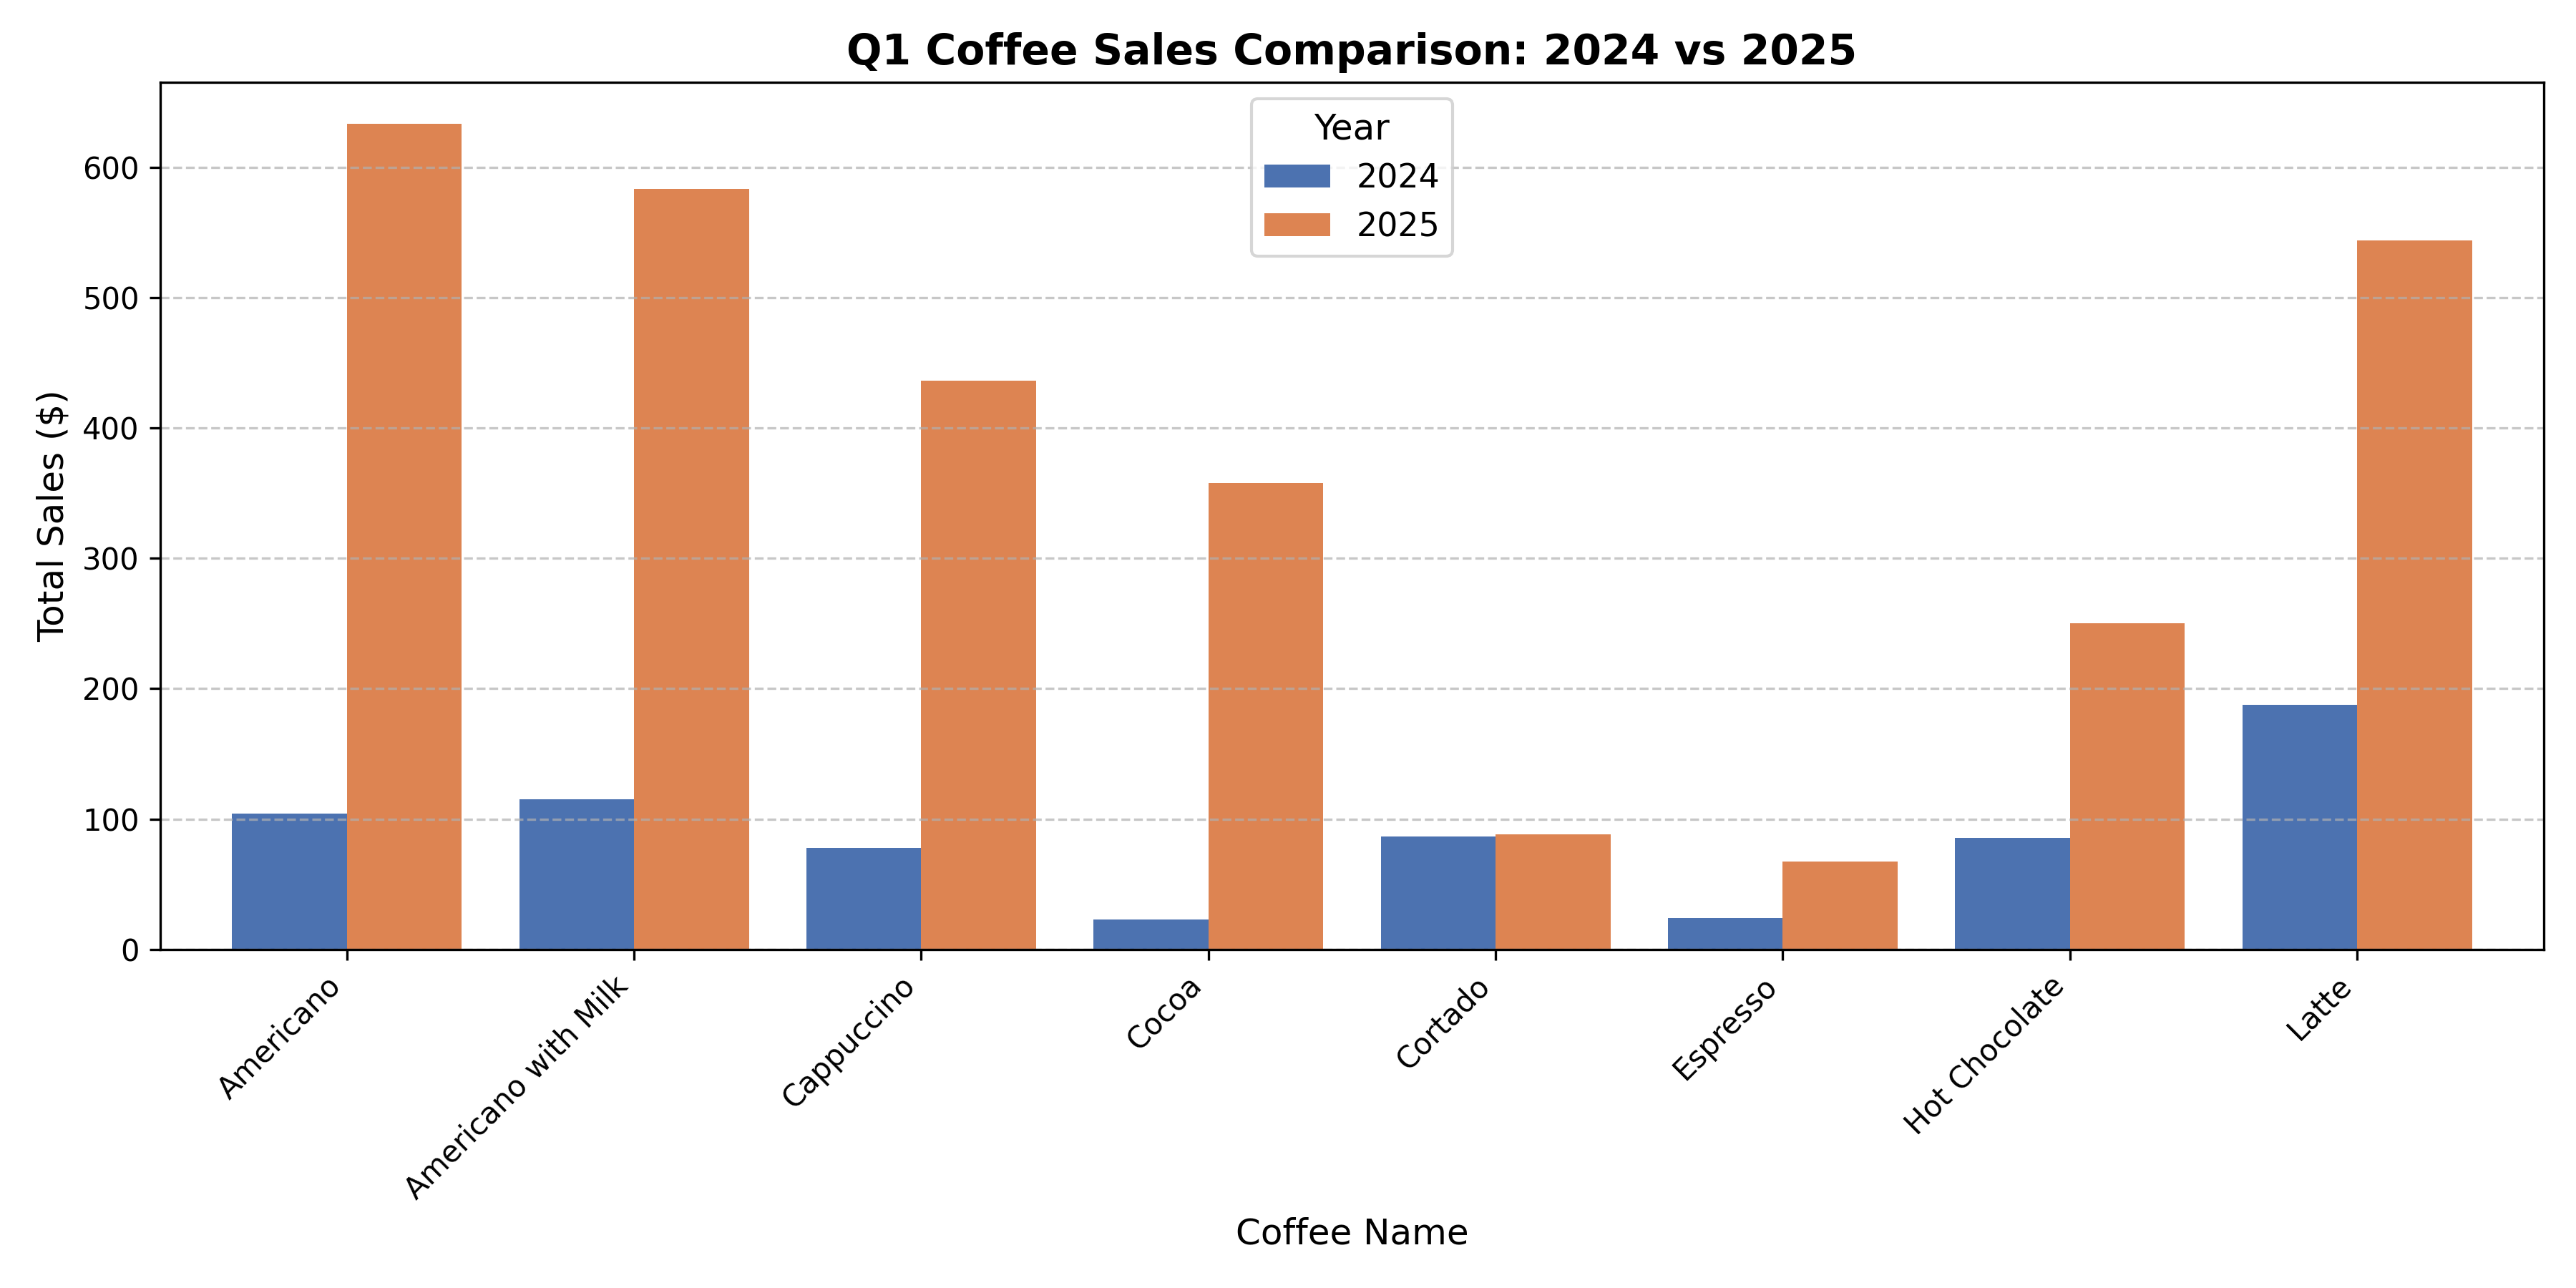

In [18]:
# Test with Qwen-VL-Plus (Qwen's Vision Model)
# Qwen-VL-Plus is capable of understanding images and following complex instructions.
# Note: 'qwen3-max' is a text-only model, so we use 'qwen-vl-plus' for the reflection step.

user_instructions="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv." 
generation_model="qwen3-max"
reflection_model="qwen-vl-plus" 
image_basename="drink_sales_qwen_vl"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)

## 5. Summary & Observations

In this lab, we successfully ported the **Reflection Pattern** workflow to use **Qwen (Tongyi Qianwen)** and **GLM (Zhipu AI)** models.

### Key Takeaways:
1.  **Model Capabilities**:
    *   **Generation**: `qwen3-max` proved to be a strong code generator, capable of understanding the data schema and producing valid Matplotlib code (V1).
    *   **Reflection (Vision)**: The reflection step requires a model with strong **Vision-Language (VLM)** capabilities.
        *   **GLM-4V**: Capable of analyzing the chart, but requires robust parsing logic as it may embed code within JSON or Markdown in varying formats.
        *   **Qwen-VL-Plus**: Demonstrated strong performance in understanding the chart's visual elements and providing actionable feedback.

2.  **Workflow Robustness**:
    *   **Client Abstraction**: Creating a unified `OpenAICompatibleClient` allowed us to seamlessly switch between providers (Alibaba Cloud & Zhipu AI) by simply changing the model name.
    *   **Error Handling**: Real-world agentic workflows require defensive coding (e.g., regex parsing for JSON/Code extraction) to handle the variability in LLM outputs.

3.  **Conclusion**:
    *   The "Generate -> Execute -> Reflect -> Regenerate" pattern effectively improves chart quality.
    *   Combining models from different providers (e.g., Qwen for generation, GLM or Qwen-VL for reflection) is a viable strategy to leverage the specific strengths of each model.